In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm
import matplotlib.patches as mpatches

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, precision_recall_fscore_support


pd.set_option('display.max_columns', None)

coeffs = ['IP', 'BT', 'NEL', 'PLTH', 'RGEO', 'KAREA', 'EPS', 'MEFF']
path = "../data/"

In [5]:
# Obtained from Optimization
#min_subset_ids = pd.read_csv(path+"R_ids_alpha_0.9998.csv")
#min_subset_ids = pd.read_csv(path+"R_ids_alpha_0.6379.csv")

min_subset_ids = pd.read_csv(path+"id_vs_frequency_decreasing_ds.csv")

DB2 = pd.read_csv(path+"DB2P8.csv")
DB5 = pd.read_csv(path+"STDB5_all_cols.csv", low_memory=False) #pd.read_csv(path+"DB5.csv")
#DB2 = DB2P8[DB5.columns] # Because DB2P8 has more columns than DB5

# There is two shots from DB2P8 missing in DB5
missing_shots = DB2[~DB2.id.isin( DB5.id.values )].reset_index(drop=True)
DB5 = pd.concat([DB5, missing_shots], axis=0, ignore_index=True)

# Labeling shots that had great impact in decreasing alpha_R
DB5.insert(loc=2,column="label",value=[0]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids.id)].index), "label"] = 1

print(
    f"{ round( (len(min_subset_ids)/len(DB5))*100     ,2)  }% of the data decreased alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids)/len(DB5))*100 ,2)  }% of the data did not decrease alpha_R"
)

34.97% of the data decreased alpha_R
65.03% of the data did not decrease alpha_R


In [6]:
min_subset_ids

,id,frequency
0,AEWB71,8297
1,UAAXGA,8302
2,53LSPJ,8320
3,FLO8WI,8320
4,TKCDLW,8297
...,...,...
2539,K3O76W,8279
2540,ZD6MZS,8294
2541,ZPPYT0,0
2542,Q48F9L,0


Class distribution can be considered almost severly skewed.

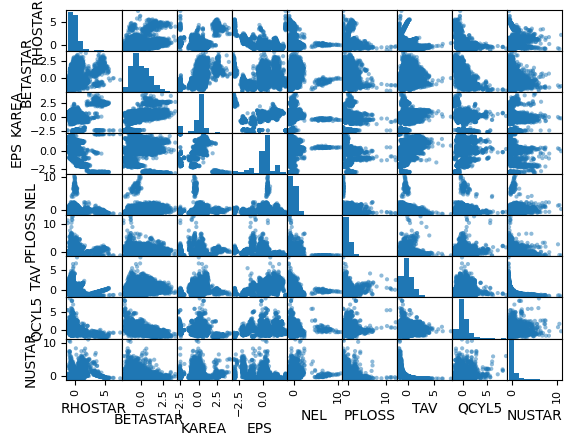

In [8]:
# UPDATED ENTROPY ANALYSIS
features = ['RHOSTAR', 'BETASTAR', 'KAREA', 'EPS', 'NEL', 'PFLOSS', 'TAV', 'QCYL5', 'NUSTAR']
DB5_ = pd.DataFrame(StandardScaler().fit_transform( DB5[features] ), columns = features)
pd.plotting.scatter_matrix(DB5_);

In [9]:
X = DB5_[features].to_numpy() # Getting scaled dataset
y = DB5[["label"]].to_numpy().reshape(-1)

# create the model | Default Configuration
model = RandomForestClassifier(random_state=71)

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=71, stratify=y)

model.fit(X_train, y_train)
y_pred= model.predict_proba(X_test)

In [10]:
# Accuracy
print(model.score(X_train,y_train))
print(model.score(X_test,y_test))

1.0
0.9418231791113147


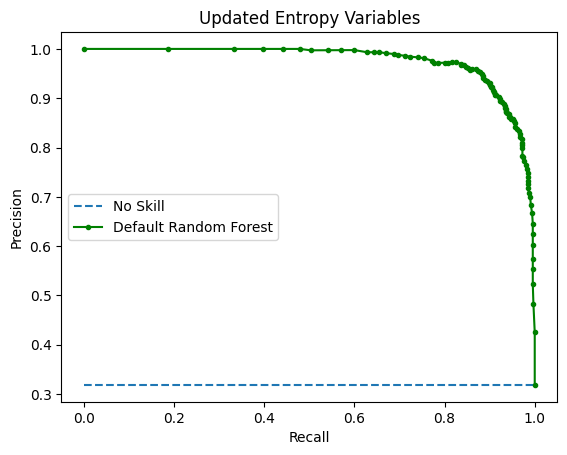

In [11]:
# keep probabilities for the positive outcome only
y_pred = y_pred[:, 1]
# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
# plot the roc curve for the model
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Default Random Forest', c="g")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("Updated Entropy Variables")
plt.legend();

In [12]:
y_pred_ = model.predict(X_test)
precision_recall_fscore_support(y_test, y_pred_, labels=[1,0])

(array([0.90687679, 0.95824916]),
 array([0.91079137, 0.9563172 ]),
 array([0.90882986, 0.95728221]),
 array([ 695, 1488]))

In [13]:
features = ['TAUTH','NEL','TAV','BT','RHOSTAR','NUSTAR','BETASTAR']
DB5_ = pd.DataFrame(StandardScaler().fit_transform( DB5[features] ), columns = features)

In [14]:
X = DB5_[features].to_numpy() # Getting scaled dataset
y = DB5[["label"]].to_numpy().reshape(-1)

# create the model | Default Configuration
model = RandomForestClassifier(random_state=71)

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=71, stratify=y)

model.fit(X_train, y_train)
y_pred= model.predict_proba(X_test)

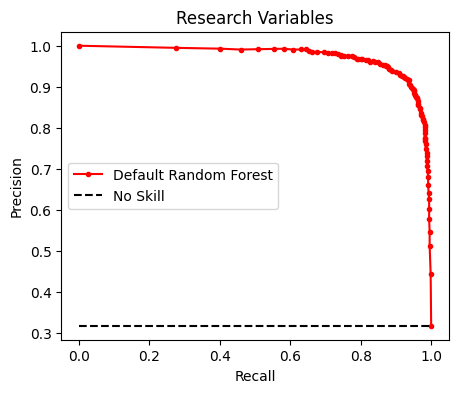

In [15]:
plt.figure(figsize=(5,4))

# keep probabilities for the positive outcome only
y_pred = y_pred[:, 1]
# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
# plot the roc curve for the model
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot(recall, precision, marker='.', label='Default Random Forest', color="r")
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill', color="k")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("Research Variables")
plt.legend();

In [16]:
y_pred_ = model.predict(X_test)
precision_recall_fscore_support(y_test, y_pred_, labels=[1,0])

(array([0.9226361 , 0.96565657]),
 array([0.92661871, 0.96370968]),
 array([0.92462312, 0.96468214]),
 array([ 695, 1488]))

## Features ordered by Entropy Analysis

In [17]:
features = ['BETASTAR', 'RHOSTAR', 'EPS', 'TAUBOHM', 'KAREA', 'NEL', 'TAUTH', 
            'RGEO', 'OMEGACYCL', 'Q95', 'TAV', 'MEFF', 'AMIN', 'QCYL5', 'IP', 
            'PLTH', 'PICRH', 'PL', 'VOL', 'NUSTAR']
DB5_ = pd.DataFrame(StandardScaler().fit_transform( DB5[features] ), columns = features)
#pd.plotting.scatter_matrix(DB5_);

In [18]:
df = DB5_[features]
df["label"] = DB5["label"]
df = df.dropna()

In [19]:
X = df[features].to_numpy() # Getting scaled dataset
y = df["label"].to_numpy().reshape(-1)

# create the model | Default Configuration
model = RandomForestClassifier(random_state=71)

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=71, stratify=y)

model.fit(X_train, y_train)
y_pred= model.predict_proba(X_test)

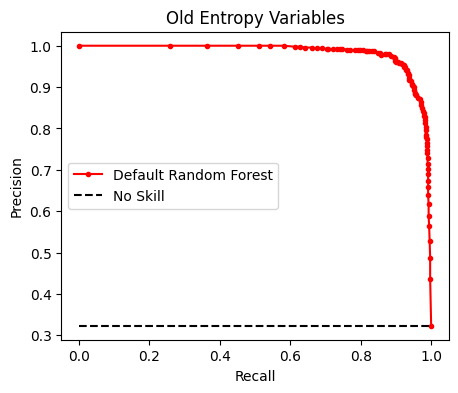

In [20]:
plt.figure(figsize=(5,4))

# keep probabilities for the positive outcome only
y_pred = y_pred[:, 1]
# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
# plot the roc curve for the model
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot(recall, precision, marker='.', label='Default Random Forest', color="r")
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill', color="k")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("Old Entropy Variables")
plt.legend();

In [21]:
y_pred_ = model.predict(X_test)
precision_recall_fscore_support(y_test, y_pred_, labels=[1,0])

(array([0.94845361, 0.96535326]),
 array([0.92661871, 0.97596154]),
 array([0.93740902, 0.97062842]),
 array([ 695, 1456]))

In [22]:
len(min_subset_ids)

2544

## ¿Qué hice para obtener este subset?

Primero, me puse a contar la presencia de todos los IDs en la parte baja de la cola del random sampling en decreasing pts del decreasing ds; de ahí salió una lista de IDs que no daban el alpha-R más bajo, ni el subset más bajo, pero si da el mejor score en Recall en RF. ¿Qué faltaría? Implementar datos categóricos para entonces poder evaluar si toman papel importante en que alpha-R baje.